In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding, \
ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier, XGBRFClassifier
import matplotlib.pyplot as plt
import warnings

import pickle

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import add_model, test_model

from seaborn import heatmap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def model_each_feature(model, verbose=1, save=True,
                   vectorization=None,
                   regularization=None,
                   regularization_strength=None,
                   class_imbalance=None):
    """Takes an unfitted model and optional entries for hyperparameter table and returns 
    the fitted model.
    fits model on each of X_t_clicks, X_t_activities, X_t_product, and all 3 features in X_t.
    Loads hyperparameter table from disk, writes entries for each of the 4 datasets.
    if save=False, will not save over hyperparameter table file on disk.
    if verbose=1, display the hyperparamter table.  
    If verbose = 2+, also display model.score_ and confusion matrix"""
    try:
        h_table = pd.read_csv('hyper_parameter_table.csv')
    except:
        h_table = None
    for train_X, validate_X, feature in ((X_t_clicks, X_val_clicks, 'clicks'), 
                                 (X_t_activities, X_val_activities, 'activities'),
                                 (X_t_product, X_val_product, 'activities_x_clicks'),
                                 (X_t, X_val, 'clicks_activities_product')):
        model.fit(train_X, y_t)

        h_table = add_model(model, validate_X, y_val, 
                                features = feature,
                                table=h_table, 
                                class_imbalance=class_imbalance)
        
        if verbose > 1:
            print(feature)
            test_model(model, validate_X, y_val, plot_confusion=True)
            
    if save:
        h_table.to_csv('hyper_parameter_table.csv', index=False)
    if verbose > 0:
        display(h_table)
    return model

In [3]:
features = 'activities_clicks_and_product'
prediction_date = 135
label_encoder = LabelEncoder()


df = pd.read_csv('../content/activities_clicks_and_product.csv')

binary_labels = {'Pass':1,
                 'Distinction':1,
                 'Withdrawn':0,
                 'Fail':0}


df = df[df.date_unregistration > prediction_date]
df = df.set_index('registration')

X = df.loc[:,:f'activities_x_clicks_{prediction_date}']
y = df.final_result.map(binary_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

X_train_clicks = X_train.loc[:,X_train.columns.str.startswith('sum_click')]
X_test_clicks = X_test.loc[:,X_test.columns.str.startswith('sum_click')]
X_t_clicks = X_t.loc[:,X_t.columns.str.startswith('sum_click')]
X_val_clicks = X_val.loc[:,X_val.columns.str.startswith('sum_click')]

X_train_activities = X_train.loc[:,X_train.columns.str.startswith('sum_activities')]
X_test_activities = X_test.loc[:,X_test.columns.str.startswith('sum_activities')]
X_t_activities = X_t.loc[:,X_t.columns.str.startswith('sum_activities')]
X_val_activities = X_val.loc[:,X_val.columns.str.startswith('sum_activities')]

X_train_product = X_train.loc[:,X_train.columns.str.startswith('activities_x_clicks')]
X_test_product = X_test.loc[:,X_test.columns.str.startswith('activities_x_clicks')]
X_t_product = X_t.loc[:,X_t.columns.str.startswith('activities_x_clicks')]
X_val_product = X_val.loc[:,X_val.columns.str.startswith('activities_x_clicks')]

h_table = None

In [4]:
model = LogisticRegression(random_state=111)
model_each_feature(model, verbose=0)

LogisticRegression(random_state=111)

In [5]:
class_imbalance = 'balanced weights'
model = LogisticRegression(class_weight='balanced', random_state=111)
model_each_feature(model, class_imbalance=class_imbalance, verbose=0)

LogisticRegression(class_weight='balanced', random_state=111)

In [6]:
model = DecisionTreeClassifier(random_state=111)
model_each_feature(model, verbose=0)

DecisionTreeClassifier(random_state=111)

In [7]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=111)
model_each_feature(model, verbose=0, class_imbalance=class_imbalance)

DecisionTreeClassifier(class_weight='balanced', random_state=111)

In [8]:
model = RandomForestClassifier(random_state=111)
model_each_feature(model, verbose=0)

RandomForestClassifier(random_state=111)

In [9]:
model = RandomForestClassifier(class_weight='balanced', random_state=111)
model_each_feature(model, verbose=0, class_imbalance=class_imbalance)

RandomForestClassifier(class_weight='balanced', random_state=111)

In [10]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)
model_each_feature(model, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [11]:
pd.read_csv('hyper_parameter_table.csv')

,model,vectorization,features,regularization,regularization_strength,class_imbalance,accuracy,f1_score
0,RandomForestClassifier,None,activities_x_clicks,None,None,None,0.784309,0.844255
1,RandomForestClassifier,None,clicks,None,None,None,0.782587,0.842872
2,RandomForestClassifier,None,clicks,None,None,balanced weights,0.779882,0.842012
3,RandomForestClassifier,None,activities,None,None,balanced weights,0.779636,0.841472
4,RandomForestClassifier,None,activities_x_clicks,None,None,balanced weights,0.779390,0.841042
5,RandomForestClassifier,None,activities,None,None,None,0.780128,0.841038
6,RandomForestClassifier,None,clicks_activities_product,None,None,balanced weights,0.778652,0.840821
7,RandomForestClassifier,None,clicks_activities_product,None,None,None,0.778652,0.840199
8,XGBClassifier,None,activities,None,None,None,0.767339,0.819051
9,XGBClassifier,None,clicks,None,None,None,0.765125,0.817574


model:  RandomForestClassifier(class_weight='balanced', random_state=111)
0.7756871425936174


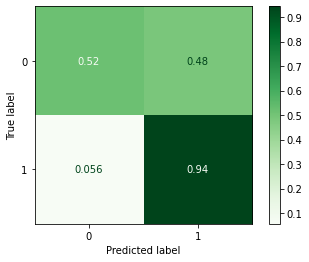

In [12]:
model = RandomForestClassifier(class_weight='balanced', random_state=111)
model.fit(X_train_product, y_train)
test_model(model, X_test_product, y_test, plot_confusion=True)